In [1]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines
import numpy as np
from jax import random as jran

ran_key = jran.PRNGKey(0)

### Call the target data generator to compute $\langle\log_{10}c(t)\vert M_0\rangle$

In [2]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


In [3]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(2, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


In [4]:
from diffprof.latin_hypercube import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.35, 13.65, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.6, 1, 100_000)

In [5]:
from diffprof.get_target_simdata import target_data_generator

N_MH_TARGETS, N_P_TARGETS = 1, 15

args = (bpl['logmp'][indx_bpl],
    mdpl2['logmp'][indx_mdpl2],
    lgconc_history_bpl[indx_bpl],
    lgconc_history_mdpl2[indx_mdpl2],
    bpl['p_tform_50'][indx_bpl],
    mdpl2['p_tform_50'][indx_mdpl2],
    N_MH_TARGETS,
    N_P_TARGETS,
       )
gen = target_data_generator(*args, lgmh_min=14.0, lgmh_max=14.25)

In [6]:
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
target_avg_log_conc_lgm0, target_std_log_conc_lgm0 = target_data[2:4]
target_avg_log_conc_p50_lgm0, _target_std_log_conc_p50_lgm0 = target_data[4:]
_target_std_log_conc_p50_lgm0.shape

(1, 15, 25)

### Call the target data model to compute $\langle\log_{10}c(t)\vert M_0,p_{50\%}\rangle$

In [7]:
from diffprof import target_data_model as tdm

_tdm_params = np.array(list(tdm.target_data_model_params_mean_lgconc.values()))
im = 0
x = [tdm.approximate_lgconc_vs_lgm_p50(TARR_FIT, lgmhalo_targets[im], p, *_tdm_params) for p in p50_targets]
_s = (p50_targets.shape[0], TARR_FIT.shape[0])
target_avg_log_conc_p50 = np.concatenate([*x]).reshape((_s))

### Call the target data model to compute $\sigma\left(\log_{10}c(t)\vert M_0,p_{50\%}\right)$

In [8]:
target_std_lgc_lgm = tdm.approx_std_lgconc_vs_lgm(
    TARR_FIT, lgmhalo_targets[im], *tdm.target_data_model_params_std_lgconc.values())

_pars = list(tdm.target_data_model_params_std_lgconc_p50.values())
target_std_log_conc_p50 = np.array(
    [tdm._scatter_vs_p50_and_lgmhalo(lgmhalo_targets[im], p, *_pars) for p in p50_targets])
target_std_log_conc_p50.shape

(15,)

In [9]:
target_std_log_conc_p50

array([0.04367107, 0.04434036, 0.04495039, 0.04609008, 0.04675426,
       0.04756494, 0.049061  , 0.050281  , 0.05128375, 0.05221726,
       0.05245263, 0.05344716, 0.05474159, 0.05490588, 0.05572934],
      dtype=float32)

In [10]:
collector = []
for im in range(N_MH_TARGETS):
    x = np.array(
        [tdm._scatter_vs_p50_and_lgmhalo(lgmhalo_targets[im], p, *_pars) for p in p50_targets])
    target_std_log_conc_p50 = np.tile(x, N_T).reshape((N_P_TARGETS, N_T))
    collector.append(target_std_log_conc_p50)
target_std_log_conc_p50_lgm0 = np.array(collector)
target_std_log_conc_p50_lgm0.shape

(1, 15, 25)

In [38]:
from dev_new_loss import _mse_loss_multimass, _get_grid_data
from diffprof.dpp_opt import get_u_param_grids
from diffprof.bpl_dpp import DEFAULT_PARAMS

n_grid = 2500
grid_key, ran_key = jran.split(ran_key, 2)
u_be_grid, u_lgtc_bl_grid = get_u_param_grids(grid_key, n_grid)

grid_data = _get_grid_data(p50_targets, TARR_FIT, u_be_grid, u_lgtc_bl_grid)

In [39]:
dpp_params = np.array(list(DEFAULT_PARAMS.values()))

_mse_loss_multimass(
    dpp_params, grid_data, lgmhalo_targets, 
    target_avg_log_conc_p50_lgm0, target_avg_log_conc_lgm0, target_std_log_conc_p50_lgm0)

DeviceArray(0.0055279, dtype=float32)

In [40]:
from diffprof.fitting_helpers.utils import jax_adam_wrapper
from dev_new_loss import _global_loss_func

global_loss_data = (grid_data, lgmhalo_targets, target_avg_log_conc_p50_lgm0,
                    target_avg_log_conc_lgm0, target_std_log_conc_p50_lgm0)
_global_loss_func(dpp_params, global_loss_data)


DeviceArray(0.0055279, dtype=float32)

In [41]:
n_steps = 200
_res = jax_adam_wrapper(_global_loss_func, dpp_params, global_loss_data, n_steps)
p_best, loss, loss_history = _res[:3]

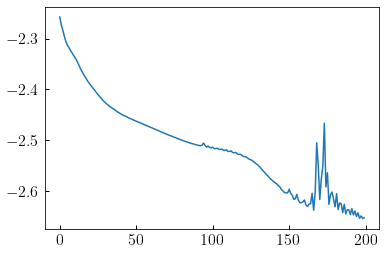

In [42]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_history))

### Check predictions

In [43]:
from diffprof.dpp_predictions import _get_preds_singlemass

im = 0
preds_singlemass = _get_preds_singlemass(
    dpp_params, lgmhalo_targets[im], TARR_FIT, p50_targets, u_be_grid, u_lgtc_bl_grid)
pred_avg_log_conc_p50, pred_avg_log_conc_lgm0, pred_std_log_conc_lgm0, pred_std_log_conc_p50 = preds_singlemass

preds_singlemass = _get_preds_singlemass(
    p_best, lgmhalo_targets[im], TARR_FIT, p50_targets, u_be_grid, u_lgtc_bl_grid)
pb_pred_avg_log_conc_p50, pb_pred_avg_log_conc_lgm0 = preds_singlemass[:2]
pb_pred_std_log_conc_lgm0, pb_pred_std_log_conc_p50 = preds_singlemass[2:]


In [44]:
target_avg_log_conc_p50.shape

(15, 25)

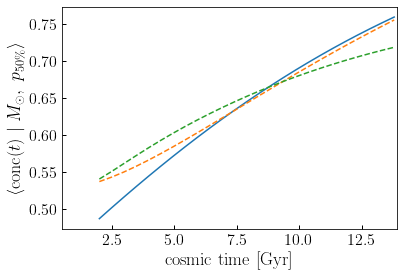

In [45]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%}\rangle$')

ip = 6
__=ax.plot(TARR_FIT, target_avg_log_conc_p50[ip, :])
__=ax.plot(TARR_FIT, pred_avg_log_conc_p50[ip, :], '--')
__=ax.plot(TARR_FIT, pb_pred_avg_log_conc_p50[ip, :], '--')

In [46]:
p50_targets

array([0.05434706, 0.13988611, 0.19993774, 0.28895674, 0.33284484,
       0.3817743 , 0.46465861, 0.52975709, 0.58431537, 0.63801596,
       0.65227142, 0.71741891, 0.82281667, 0.83904601, 0.93880427])